In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,classification_report,precision_score,roc_auc_score,matthews_corrcoef,precision_recall_fscore_support,make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn import model_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.combine import SMOTETomek
 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,StackingClassifier,VotingClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [144]:
df=pd.read_excel("C:/Users/saich/OneDrive/Desktop/Diabetes_Classification.xlsx")

In [145]:
df.drop(labels="Patient number",axis=1,inplace=True)

In [146]:
df.replace({'Gender':{"female":"F","male":"M"}},inplace=True)

In [147]:
le=LabelEncoder()
df["Gender"]=le.fit_transform(df["Gender"])

In [148]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Cholesterol        50.000
Glucose            26.750
HDL Chol           21.000
Chol/HDL ratio      2.200
Age                26.000
Gender              1.000
Height              6.000
Weight             49.750
BMI                 8.175
Systolic BP        26.000
Diastolic BP       15.000
waist               8.000
hip                 7.000
Waist/hip ratio     0.100
dtype: float64


In [149]:
df=df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [150]:
target=df["Diabetes"]
features=df.drop(columns="Diabetes",axis=1)

In [151]:
target.value_counts()

No diabetes    277
Diabetes        13
Name: Diabetes, dtype: int64

In [152]:
sm = SMOTETomek(random_state=42,sampling_strategy="minority") 
new_features, new_target = sm.fit_resample(features, target)

In [153]:
scaler = StandardScaler()
X_res=pd.DataFrame(scaler.fit_transform(new_features),columns=list(new_features.columns))
y_res=new_target

In [154]:
y_res.value_counts()

Diabetes       277
No diabetes    277
Name: Diabetes, dtype: int64

In [155]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,Y_train1,Y_test1=train_test_split(X_res,
                                               y_res,
                                               test_size=0.35,
                                               random_state=42)

# Function to get scores(KFold cross validation)

In [156]:
def evaluate_model_accuracy(model, X, y):
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
    return scores


def evaluate_model_recall_positive(model,X,y):
    scoring = {'recall' : make_scorer(recall_score,pos_label="Diabetes") }
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_recall"]

def evaluate_model_recall_negative(model,X,y):
    scoring = {'recall' : make_scorer(recall_score,pos_label="No diabetes") }
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_recall"]

def evaluate_model_roc_auc(model, X, y):
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
    return scores

def evaluate_model_matthews_corrcoef(model,X,y):
    score=matthews_corrcoef(y,model.predict(X))
    return score

def evaluate_model_precision(model,X,y):
    scoring = {'precision' : make_scorer(recall_score,pos_label="Diabetes") }
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_precision"]

def evaluate_model_f1score(model,X,y):
    scoring = {'f1' : make_scorer(recall_score,pos_label="Diabetes") }
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    results =cross_validate(estimator=model,
                                    X=X,
                                    y=y,
                                    cv=kfold,
                                    scoring=scoring)
    return results["test_f1"]


# Logistic Regression

In [157]:
LR=LogisticRegression(C=11.288378916846883,penalty="l2",solver= 'liblinear',random_state=42)

LR.fit(X_train1,Y_train1)

LogisticRegression(C=11.288378916846883, random_state=42, solver='liblinear')

In [158]:
print(classification_report(Y_test1,LR.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.87      0.80      0.83        96
 No diabetes       0.82      0.88      0.85        98

    accuracy                           0.84       194
   macro avg       0.84      0.84      0.84       194
weighted avg       0.84      0.84      0.84       194



In [159]:
cv = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
scoring = {'recall' : make_scorer(recall_score,pos_label="Diabetes") }

In [160]:
# for recall
results1 =cross_validate(estimator=LR,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring=scoring)
# for accuracy
accuracy1 = model_selection.cross_val_score(LR, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [161]:
print("Accuracy",np.mean(accuracy1))
print("recall score is :",np.mean(results1["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(LR, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results1["score_time"]))
print("fit time is :",np.mean(results1["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=LR,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8166666666666668
recall score is : 0.8533626873642353
roc-auc score is 0.9041860916860915
score time is : 0.0036882638931274416
fit time is : 0.013091850280761718
recall score for No diabetes is : 0.7906561881045324


# Grid Search

In [162]:
# # # # param_grid = [
# # # #     {
# # # #      'penalty' : ['l1', 'l2'],
# # # #     'C' : np.logspace(-4, 4, 20),
# # # #     'solver' : ['liblinear']}
# # # # ]

# # # param_grid = [
# # #     {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
# # # ]

# param_grid = dict(n_neighbors=list(range(10, 31)))
# param_grid = dict(n_estimators=[i for i in [10,20,30,40,50,60,70,80,90,100]])
# grid=GridSearchCV(etc,param_grid,cv=10,n_jobs=-1)
    
# # grid = RandomizedSearchCV(knn, param_distributions = param_grid, cv = 10,n_jobs=-1)
# grid=GridSearchCV(knn,param_grid,cv=5,n_jobs=-1)

In [163]:
# grid.fit(X_train1,Y_train1)

In [164]:
# grid.best_params_

# Decsison Trees

In [165]:
classifier1=DecisionTreeClassifier(criterion="entropy",max_depth=6,random_state=42)

In [166]:
classifier1.fit(X_train1,Y_train1)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [167]:
print(classification_report(Y_test1,classifier1.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.92      0.96      0.94        96
 No diabetes       0.96      0.92      0.94        98

    accuracy                           0.94       194
   macro avg       0.94      0.94      0.94       194
weighted avg       0.94      0.94      0.94       194



In [168]:
results2 =cross_validate(estimator=classifier1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy2 = model_selection.cross_val_score(classifier1, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [169]:
print("Accuracy",np.mean(accuracy2))
print("recall score is :",np.mean(results1["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(classifier1, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results1["score_time"]))
print("fit time is :",np.mean(results1["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=classifier1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=model_selection.KFold(n_splits=10),
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.9222222222222223
recall score is : 0.8533626873642353
roc-auc score is 0.906456154956155
score time is : 0.0036882638931274416
fit time is : 0.013091850280761718
recall score for No diabetes is : 0.8764231601731602


# KNN

In [170]:
from sklearn.neighbors import KNeighborsClassifier  
knn= KNeighborsClassifier(n_neighbors=11,n_jobs=-1)  
knn.fit(X_train1, Y_train1) 

KNeighborsClassifier(n_jobs=-1, n_neighbors=11)

In [171]:
print(classification_report(Y_test1,knn.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.81      1.00      0.89        96
 No diabetes       1.00      0.77      0.87        98

    accuracy                           0.88       194
   macro avg       0.90      0.88      0.88       194
weighted avg       0.90      0.88      0.88       194



In [172]:
results3 =cross_validate(estimator=knn,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy3 = model_selection.cross_val_score(knn, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [173]:
print("Accuracy",np.mean(accuracy3))
print("recall score for Diabetes is :",np.mean(results3["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(knn, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results3["score_time"]))
print("fit time is :",np.mean(results3["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=knn,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8638888888888889
recall score for Diabetes is : 1.0
roc-auc score is 0.9344652014652015
score time is : 0.06756148338317872
fit time is : 0.005186271667480469
recall score for No diabetes is : 0.7307304386285407


# Naive bayes

In [174]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train1, Y_train1)

GaussianNB()

In [175]:
print(classification_report(Y_test1,nb.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.87      0.82      0.84        96
 No diabetes       0.83      0.88      0.86        98

    accuracy                           0.85       194
   macro avg       0.85      0.85      0.85       194
weighted avg       0.85      0.85      0.85       194



In [176]:
results4 =cross_validate(estimator=nb,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy4 = model_selection.cross_val_score(nb, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [177]:
print("Accuracy",np.mean(accuracy4))
print("recall score is :",np.mean(results4["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(nb, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results4["score_time"]))
print("fit time is :",np.mean(results4["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=nb,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=model_selection.KFold(n_splits=10),
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8416666666666668
recall score is : 0.8470257889685137
roc-auc score is 0.9185032745032744
score time is : 0.0020639181137084963
fit time is : 0.06796011924743653
recall score for No diabetes is : 0.8493380230880231


# SVM

In [178]:
svm = SVC(kernel='rbf',probability=True)
svm.fit(X_train1, Y_train1)

SVC(probability=True)

In [179]:
print(classification_report(Y_test1,svm.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.92      1.00      0.96        96
 No diabetes       1.00      0.92      0.96        98

    accuracy                           0.96       194
   macro avg       0.96      0.96      0.96       194
weighted avg       0.96      0.96      0.96       194



In [180]:
results5 =cross_validate(estimator=svm,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy5 = model_selection.cross_val_score(svm, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [181]:
print("Accuracy",np.mean(accuracy5))
print("recall score is :",np.mean(results5["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(svm, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results5["score_time"]))
print("fit time is :",np.mean(results5["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=svm,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.9666666666666666
recall score is : 0.9941176470588236
roc-auc score is 0.9764568764568764
score time is : 0.004008698463439942
fit time is : 0.09463281631469726
recall score for No diabetes is : 0.9385977651930337


# Random Forests

In [182]:
rf=RandomForestClassifier(random_state=42)
rf.fit(X_train1, Y_train1)

RandomForestClassifier(random_state=42)

In [183]:
print(classification_report(Y_test1,rf.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.98      1.00      0.99        96
 No diabetes       1.00      0.98      0.99        98

    accuracy                           0.99       194
   macro avg       0.99      0.99      0.99       194
weighted avg       0.99      0.99      0.99       194



In [184]:
results6 =cross_validate(estimator=rf,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="Diabetes") })

accuracy6 = model_selection.cross_val_score(rf, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [185]:
print("Accuracy",np.mean(accuracy6))
print("recall score is :",np.mean(results6["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(rf, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("score time is :",np.mean(results6["score_time"]))
print("fit time is :",np.mean(results6["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=rf,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=model_selection.KFold(n_splits=10),
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.9805555555555555
recall score is : 1.0
roc-auc score is 0.9942252192252192
score time is : 0.022417140007019044
fit time is : 0.332279896736145
recall score for No diabetes is : 0.9710227272727273


# Ensembel

In [186]:
model1= VotingClassifier(estimators=[ ('dt', classifier1),('knn',knn),('svm',svm),('LR',LR)], voting='soft')
model1.fit(X_train1,Y_train1)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=6,
                                                     random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=11)),
                             ('svm', SVC(probability=True)),
                             ('LR',
                              LogisticRegression(C=11.288378916846883,
                                                 random_state=42,
                                                 solver='liblinear'))],
                 voting='soft')

In [187]:
print(classification_report(Y_test1,model1.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.93      1.00      0.96        96
 No diabetes       1.00      0.93      0.96        98

    accuracy                           0.96       194
   macro avg       0.97      0.96      0.96       194
weighted avg       0.97      0.96      0.96       194



In [188]:
results =cross_validate(estimator=model1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring=scoring)
accuracy = model_selection.cross_val_score(LR, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1)

In [189]:
print("Accuracy",np.mean(accuracy))
print("recall score is :",np.mean(results["test_recall"]))
print("score time is :",np.mean(results["score_time"]))
print("fit time is :",np.mean(results["fit_time"]))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=model1,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))

Accuracy 0.8166666666666668
recall score is : 0.9949999999999999
score time is : 0.04014756679534912
fit time is : 0.03747372627258301
recall score for No diabetes is : 0.9112737486298867


# Ensemble of random forest regression classifiers.

In [190]:
logbagClf = BaggingClassifier(rf, n_estimators = 15,random_state=8)
logbagClf.fit(X_train1, Y_train1)

BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  n_estimators=15, random_state=8)

In [191]:
print(classification_report(Y_test1,logbagClf.predict(X_test1)))

              precision    recall  f1-score   support

    Diabetes       0.96      1.00      0.98        96
 No diabetes       1.00      0.96      0.98        98

    accuracy                           0.98       194
   macro avg       0.98      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194



In [192]:
print('Accuracy: %.3f ' % (np.mean(model_selection.cross_val_score(logbagClf, X_train1,Y_train1, scoring='accuracy', cv=cv, n_jobs=-1))*100))

Accuracy: 97.778 


In [193]:
print("recall score is :",np.mean(cross_validate(estimator=LR,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring=scoring)["test_recall"]))
print("roc-auc score is",np.mean(list(cross_val_score(logbagClf, X_test1, Y_test1, cv=cv, scoring='roc_auc'))))
print("recall score for No diabetes is :",np.mean(cross_validate(estimator=logbagClf,
                                    X=X_train1,
                                    y=Y_train1,
                                    cv=cv,
                                    scoring={'recall' : make_scorer(recall_score,pos_label="No diabetes") })["test_recall"]))


recall score is : 0.8533626873642353
roc-auc score is 0.9882700632700633
recall score for No diabetes is : 0.9548147863264299


# Gradient boost

In [194]:
Gboost= GradientBoostingClassifier(learning_rate=0.9,random_state=42,n_estimators=250)
Gboost.fit(X_train1, Y_train1)

GradientBoostingClassifier(learning_rate=0.9, n_estimators=250, random_state=42)

In [195]:
def get_models():
    models = dict()
    n_trees = [10,30, 50, 100,250, 500]
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n)
    return models

In [196]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model_recall_positive(model, X_test1,Y_test1)
    results.append(scores)
    names.append(name)
    print('>%s %.3f ' % (name, np.mean(scores)))

>10 0.860 
>30 0.960 
>50 0.977 
>100 0.977 
>250 0.991 
>500 0.981 


# Adaboost

In [197]:
Adaboost = AdaBoostClassifier(random_state=42,n_estimators=750)
Adaboost.fit(X_train1, Y_train1)

AdaBoostClassifier(n_estimators=750, random_state=42)

In [198]:
def get_models():
    models = dict()
    n_trees = [10,30, 50, 100,250, 500,750,1000]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n)
    return models

In [199]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model_recall_positive(model, X_test1,Y_test1)
    results.append(scores)
    names.append(name)
    print('>%s %.3f ' % (name, np.mean(scores)))

>10 0.902 
>30 0.933 
>50 0.912 
>100 0.921 
>250 0.958 
>500 0.962 
>750 0.981 
>1000 0.967 


# Confusion Matrix

In [200]:
def conf_matrix(y_true,x_true,model):
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_true, model.predict(x_true)), annot=True)
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Diabetes', 'No Diabetes']); ax.yaxis.set_ticklabels(['Diabetes', 'No Diabetes']);
    return ax

# ExtraTreesClassifier

In [201]:
etc = ExtraTreesClassifier(n_estimators=50,random_state=42)
etc.fit(X_train1,Y_train1)

ExtraTreesClassifier(n_estimators=50, random_state=42)

In [202]:
def get_models():
    models = dict()
    n_trees = [10,30, 50, 100,250, 500, 1000]
    for n in n_trees:
        models[str(n)] = ExtraTreesClassifier(n_estimators=n)
    return models

In [203]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model_recall_positive(model, X_test1,Y_test1)
    results.append(scores)
    names.append(name)
    print('>%s %.3f ' % (name, np.mean(scores)))

>10 0.954 
>30 0.963 
>50 0.982 
>100 0.973 
>250 0.963 
>500 0.973 
>1000 0.973 


# Ensemble of Adaboost,Gboost,Etc

In [204]:
model2=VotingClassifier(estimators=[ ('Adaboost', Adaboost),('Gboost',Gboost),('etc',etc)], voting='soft')
model2.fit(X_train1,Y_train1)

VotingClassifier(estimators=[('Adaboost',
                              AdaBoostClassifier(n_estimators=750,
                                                 random_state=42)),
                             ('Gboost',
                              GradientBoostingClassifier(learning_rate=0.9,
                                                         n_estimators=250,
                                                         random_state=42)),
                             ('etc',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=42))],
                 voting='soft')

# Ensemble of rf,Gboost,Etc

In [205]:
model3=VotingClassifier(estimators=[ ('rf', Adaboost),('Gboost',rf),('etc',etc)], voting='soft')
model3.fit(X_train1,Y_train1)

VotingClassifier(estimators=[('rf',
                              AdaBoostClassifier(n_estimators=750,
                                                 random_state=42)),
                             ('Gboost',
                              RandomForestClassifier(random_state=42)),
                             ('etc',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=42))],
                 voting='soft')

# testing scores

In [206]:
print("accuracy is: ",np.mean(evaluate_model_accuracy(classifier1,X_test1,Y_test1)))
print("diabetes recall is: ",np.mean(evaluate_model_recall_positive(classifier1,X_test1,Y_test1)))
print("no diabetes recall is: ",np.mean(evaluate_model_recall_negative(classifier1,X_test1,Y_test1)))
print("roc_auc is: ",np.mean(evaluate_model_roc_auc(classifier1,X_test1,Y_test1)))
print("matthews_corrcoef is: ",evaluate_model_matthews_corrcoef(classifier1,X_test1,Y_test1))
print("Precision is: ",np.mean(evaluate_model_precision(classifier1,X_test1,Y_test1)))

accuracy is:  0.9123684210526315
diabetes recall is:  0.959047619047619
no diabetes recall is:  0.8638400488400488
roc_auc is:  0.906456154956155
matthews_corrcoef is:  0.8770736650497879
Precision is:  0.959047619047619


# showing Confusion matrix

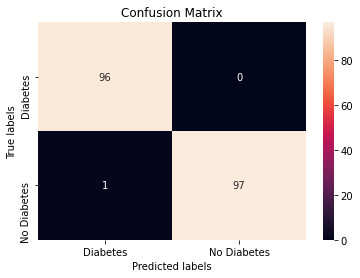

In [207]:
conf_matrix(Y_test1,X_test1,etc)
plt.show()

# total scores

In [208]:
scores_df=pd.DataFrame()

LR_scores={'accuracy': [0.8505263157894737],
 'recall_positive': [0.8851839826839827],

 'roc_auc': [0.9041860916860915],
 'precision': [0.8851839826839827],
 "f1_score":[0.8851839826839827]}


scores_df=pd.DataFrame(LR_scores,index=["LR"])

scores_df.loc["knn"] = [np.mean(evaluate_model_accuracy(knn,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(knn,X_test1,Y_test1)),
               
                       np.mean(evaluate_model_roc_auc(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(knn,X_test1,Y_test1))]


scores_df.loc["classifier1"] = [np.mean(evaluate_model_accuracy(classifier1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(classifier1,X_test1,Y_test1)),
                 
                       np.mean(evaluate_model_roc_auc(classifier1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(classifier1,X_test1,Y_test1)),
                               np.mean(evaluate_model_f1score(classifier1,X_test1,Y_test1))]

scores_df.loc["svm"] = [np.mean(evaluate_model_accuracy(svm,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(svm,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(svm,X_test1,Y_test1))]

scores_df.loc["nb"] = [np.mean(evaluate_model_accuracy(nb,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(nb,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(nb,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(nb,X_test1,Y_test1)),
                      np.mean(evaluate_model_f1score(nb,X_test1,Y_test1))]

scores_df.loc["rf"] = [np.mean(evaluate_model_accuracy(rf,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(rf,X_test1,Y_test1)),
                
                       np.mean(evaluate_model_roc_auc(rf,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(rf,X_test1,Y_test1)),
                      np.mean(evaluate_model_f1score(rf,X_test1,Y_test1))]

scores_df.loc["Gboost"] = [np.mean(evaluate_model_accuracy(Gboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Gboost,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(Gboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Gboost,X_test1,Y_test1)),
                          np.mean(evaluate_model_f1score(Gboost,X_test1,Y_test1))]

scores_df.loc["Adaboost"] = [np.mean(evaluate_model_accuracy(Adaboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Adaboost,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(Adaboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Adaboost,X_test1,Y_test1)),
                            np.mean(evaluate_model_f1score(Adaboost,X_test1,Y_test1))]

scores_df.loc["etc"] = [np.mean(evaluate_model_accuracy(etc,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(etc,X_test1,Y_test1)),
                     
                       np.mean(evaluate_model_roc_auc(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(etc,X_test1,Y_test1))]

scores_df.loc["model1"] = [np.mean(evaluate_model_accuracy(model1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model1,X_test1,Y_test1)),
                     
                       np.mean(evaluate_model_roc_auc(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model1,X_test1,Y_test1))]

scores_df.loc["model2"] = [np.mean(evaluate_model_accuracy(model2,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model2,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model2,X_test1,Y_test1))]

scores_df.loc["model3"]=[np.mean(evaluate_model_accuracy(model3,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model3,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model3,X_test1,Y_test1))]


scores_df.loc["LR"] = [np.mean(evaluate_model_accuracy(LR,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(LR,X_test1,Y_test1)),
               
                       np.mean(evaluate_model_roc_auc(LR,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(LR,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(LR,X_test1,Y_test1))]

# individual scores

In [209]:
individual_scores=pd.DataFrame()

LR_scores={'accuracy': [0.8868421052631579],
 'recall_positive': [0.9058658008658009],

 'roc_auc': [0.9233404928404928],
 'precision': [0.9058658008658009],
 "f1_score":[0.9058658008658009]}

individual_scores=pd.DataFrame(LR_scores,index=["LR"])

individual_scores.loc["knn"] = [np.mean(evaluate_model_accuracy(knn,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(knn,X_test1,Y_test1)),
               
                       np.mean(evaluate_model_roc_auc(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(knn,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(knn,X_test1,Y_test1))]


individual_scores.loc["classifier1"] = [np.mean(evaluate_model_accuracy(classifier1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(classifier1,X_test1,Y_test1)),
                 
                       np.mean(evaluate_model_roc_auc(classifier1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(classifier1,X_test1,Y_test1)),
                               np.mean(evaluate_model_f1score(classifier1,X_test1,Y_test1))]

individual_scores.loc["svm"] = [np.mean(evaluate_model_accuracy(svm,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(svm,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(svm,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(svm,X_test1,Y_test1))]

individual_scores.loc["nb"] = [np.mean(evaluate_model_accuracy(nb,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(nb,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(nb,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(nb,X_test1,Y_test1)),
                      np.mean(evaluate_model_f1score(nb,X_test1,Y_test1))]

individual_scores.loc["LR"] = [np.mean(evaluate_model_accuracy(LR,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(LR,X_test1,Y_test1)),
               
                       np.mean(evaluate_model_roc_auc(LR,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(LR,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(LR,X_test1,Y_test1))]

# custom_ensemble_scores

In [210]:
custom_ensemble_scores=pd.DataFrame()

model1_scores={'accuracy': [0.9021052631578949],
 'recall_positive': [ 0.9058658008658009],

 'roc_auc': [0.9726289266289267],
 'precision': [0.9058658008658009],
 "f1_score":[ 0.9058658008658009]}

custom_ensemble_scores=pd.DataFrame(model1_scores,index=["model1"])


custom_ensemble_scores.loc["model2"] = [np.mean(evaluate_model_accuracy(model2,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model2,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model2,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model2,X_test1,Y_test1))]

custom_ensemble_scores.loc["model3"]=[np.mean(evaluate_model_accuracy(model3,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model3,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model3,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model3,X_test1,Y_test1))]

custom_ensemble_scores.loc["model1"] = [np.mean(evaluate_model_accuracy(model1,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(model1,X_test1,Y_test1)),
                    
                       np.mean(evaluate_model_roc_auc(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(model1,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(model1,X_test1,Y_test1))]


# Ensemble scores

In [211]:
Ensemble_scores=pd.DataFrame()

rf_scores={'accuracy': [0.9689473684210526],
 'recall_positive': [0.9517424242424243],

 'roc_auc': [0.9931235431235432],
 'precision': [0.9608333333333334],
 "f1_score":[0.9608333333333334]}

Ensemble_scores=pd.DataFrame(rf_scores,index=["rf"])


Ensemble_scores.loc["Gboost"] = [np.mean(evaluate_model_accuracy(Gboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Gboost,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(Gboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Gboost,X_test1,Y_test1)),
                          np.mean(evaluate_model_f1score(Gboost,X_test1,Y_test1))]

Ensemble_scores.loc["Adaboost"] = [np.mean(evaluate_model_accuracy(Adaboost,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(Adaboost,X_test1,Y_test1)),
                  
                       np.mean(evaluate_model_roc_auc(Adaboost,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(Adaboost,X_test1,Y_test1)),
                            np.mean(evaluate_model_f1score(Adaboost,X_test1,Y_test1))]

Ensemble_scores.loc["etc"] = [np.mean(evaluate_model_accuracy(etc,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(etc,X_test1,Y_test1)),
                     
                       np.mean(evaluate_model_roc_auc(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(etc,X_test1,Y_test1)),
                       np.mean(evaluate_model_f1score(etc,X_test1,Y_test1))]

Ensemble_scores.loc["rf"] = [np.mean(evaluate_model_accuracy(rf,X_test1,Y_test1)),
                        np.mean(evaluate_model_recall_positive(rf,X_test1,Y_test1)),
              
                       np.mean(evaluate_model_roc_auc(rf,X_test1,Y_test1)),
                       np.mean(evaluate_model_precision(rf,X_test1,Y_test1)),
                          np.mean(evaluate_model_f1score(rf,X_test1,Y_test1))]

In [212]:
individual_scores

,accuracy,recall_positive,roc_auc,precision,f1_score
LR,0.850526,0.885184,0.904186,0.885184,0.885184
knn,0.835000,0.946818,0.934465,0.946818,0.946818
classifier1,0.912368,0.959048,0.906456,0.959048,0.959048
svm,0.886579,0.891851,0.976457,0.891851,0.891851
nb,0.849737,0.828279,0.918503,0.828279,0.828279


In [213]:
Ensemble_scores

,accuracy,recall_positive,roc_auc,precision,f1_score
rf,0.948421,0.959199,0.994225,0.959199,0.959199
Gboost,0.953158,0.990909,0.992477,0.990909,0.990909
Adaboost,0.943158,0.980909,0.975710,0.980909,0.980909
etc,0.958947,0.962727,0.996970,0.962727,0.962727


In [214]:
custom_ensemble_scores

,accuracy,recall_positive,roc_auc,precision,f1_score
model1,0.907105,0.922532,0.976274,0.930866,0.930866
model2,0.953158,0.990909,0.997980,0.990909,0.990909
model3,0.963947,0.981818,0.996698,0.981818,0.981818
